In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf
import datetime
from datetime import timedelta

# Fetching Information

First we will fetch all the finantial information regarding the stock whose price we will attempt to predict. Then, we will keep only the close price for each day, and we will graph this. Lastly, we want to train out newral network with about 80% of our available data, so we will calculate how many registers this is.

In [2]:
AAPL_stock_information = yf.download('AAPL', start = '2000-07-15', end = '2019-07-14') # Fetching apple information

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Historic close price for AAPL'}, xlabel='Date', ylabel='Close Price USD ($)'>

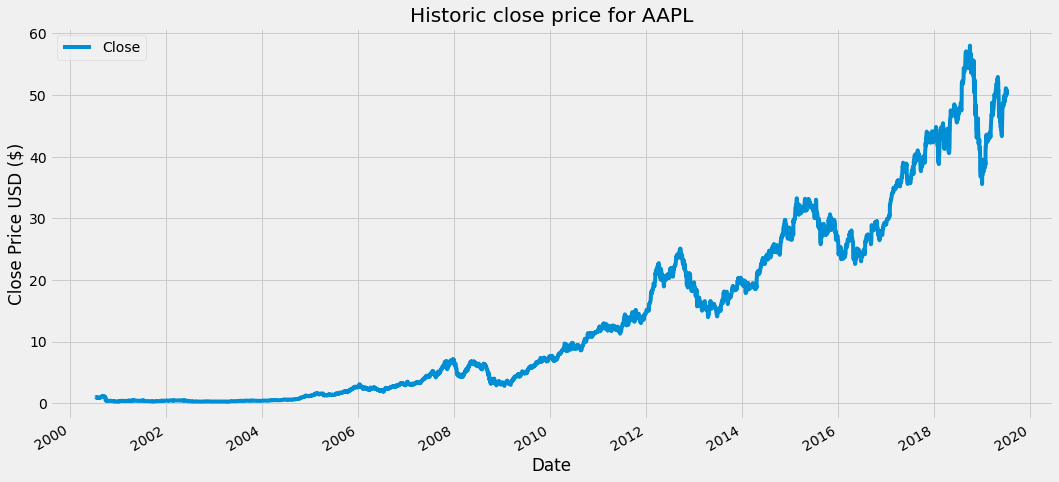

In [3]:
AAPL_close_price = AAPL_stock_information.filter(['Close']) # Droppping everything that isn't close price
AAPL_close_price.plot(title = 'Historic close price for AAPL', figsize=(16,8), xlabel = 'Date', ylabel = 'Close Price USD ($)') # Graphing

In [4]:
training_data_len = math.ceil( AAPL_close_price.shape[0] *.8) # Calculates number of training registers
training_data_len

3822

# Scaling

Now we will scale oll of our closing prices on a scale of 0 to 1, inclusive. This is generally a good practice when it comes to neural networks. We will use the MinMax method, which goes as follows:

$ X_{new} = \frac{X - X_{min}}{X_{max}-X_{min}} $

For time's sake, we will use the preimplemented MinMaxScaler package of the python *sklean* library. But, before we do this, we must make one last trasformation. Up until now we have been storing our closing prices in a *pandas* dataframe, but the pre-imlemented MinMaxScaler requires an array input, probably because the operations required to find the largest and smallest numbers iun this data structure are long, therefore we will transform this *pandas* dataset into a *numpy* array, in which theses operations can be done faster.

In [5]:
array_of_closing_values = AAPL_close_price.values # Transfor the dataframe into an array

scaler = MinMaxScaler(feature_range=(0, 1)) # Instanciate a MinMaxScaler with a [0,1] range
scaled_close_prices = scaler.fit_transform(array_of_closing_values) # Pass the data to the scaler, for it to scale it :)

scaled_close_prices

array([[0.01396615],
       [0.0136378 ],
       [0.01222782],
       ...,
       [0.87522323],
       [0.86882001],
       [0.87552612]])

# Creating the Training Data

For this problem in particular we will create 2 data sub-sets. The first one we will call independent train or $x train$ and the decond one we will call dependant train, or $y train$. The independant train will have sets of 60 days worth of information, and the dependant train will store the closing price information for the day after the ones stored in the $x train$ position with the same index.

In [6]:
train_data = scaled_close_prices[0:training_data_len , : ] # Selects from the scaled prices the number of rows defined as training_data_len
print(train_data)

# Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for row in range(60, len(train_data)):
    x_train.append(train_data[row-60:row,0])
    y_train.append(train_data[row,0])
    
# Turn the x and y trains into arrays, because the neural network trainer only takes 3-dimentional arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

[[0.01396615]
 [0.0136378 ]
 [0.01222782]
 ...
 [0.48657234]
 [0.49055273]
 [0.49349476]]


# Building the Model

In [7]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

3762/3762 [==============================] - 141s 37ms/step - loss: 2.6909e-04


In [20]:
test_data = scaled_close_prices[training_data_len - 60: , : ] # We declare the test data to be the last 20% of out total information

#Create the x_test and y_test data sets
x_test = []
y_test =  array_of_closing_values[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [21]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) # Undo scaling

<ipython-input-22-a2bb6d1fc640>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


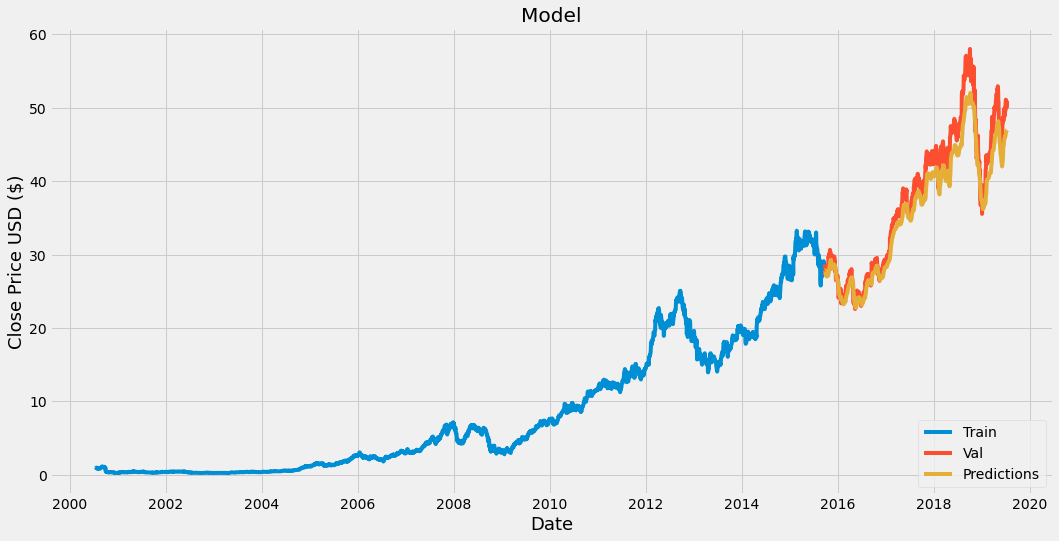

In [22]:
#Plot/Create the data for the graph
train = AAPL_close_price[:training_data_len]
valid = AAPL_close_price[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [50]:
pd.set_option('display.max_rows', None)
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2015-09-25,28.677500,27.827877
2015-09-28,28.110001,27.849489
2015-09-29,27.264999,27.788317
2015-09-30,27.575001,27.589100
2015-10-01,27.395000,27.414766
2015-10-02,27.594999,27.249702
2015-10-05,27.695000,27.142609
2015-10-06,27.827499,27.087179
2015-10-07,27.695000,27.078032


In [48]:
array_of_predictions = valid[['Predictions']].values
array_of_real_prices = valid[['Close']].values

success = 0
failure = 0

for i in range (array_of_predictions.shape[0] - 1):
    if ((array_of_predictions[i + 1] < array_of_real_prices[i]) and (array_of_real_prices[i+1] < array_of_real_prices[i])):
        success = success + 1
    elif ((array_of_predictions[i+1] > array_of_real_prices[i]) and (array_of_real_prices[i+1] > array_of_real_prices[i])):
        success = success + 1
    elif ((array_of_predictions[i+1] < array_of_real_prices[i]) and (array_of_real_prices[i+1] > array_of_real_prices[i])):
        failure = failure + 1
        print(i)
    elif ((array_of_predictions[i+1] > array_of_real_prices[i]) and (array_of_real_prices[i+1] < array_of_real_prices[i])):
        failure = failure + 1
        print(i)
        
print(f'Success = {success}, Failure = {failure}, Success rate = {success/(success+failure) * 100}')

4
5
6
9
11
13
15
16
18
19
22
23
25
26
29
37
38
39
41
44
48
52
54
55
58
60
61
64
67
69
70
77
80
82
89
95
96
97
100
102
103
104
106
107
108
109
112
113
114
115
116
117
119
121
125
126
128
129
131
133
134
135
136
137
141
147
148
149
151
152
153
161
163
164
165
166
167
172
173
174
176
179
181
183
184
186
188
190
191
192
194
195
196
197
198
200
202
203
204
209
210
212
214
215
216
217
218
221
222
226
228
234
235
236
238
242
243
244
249
251
252
253
255
257
258
259
260
261
262
263
265
271
272
280
282
288
290
291
292
294
299
301
302
303
304
306
308
309
310
311
312
314
315
319
321
322
323
324
325
328
331
332
334
335
336
339
341
342
343
344
345
347
348
349
351
352
353
355
356
357
358
360
362
365
366
368
369
371
373
376
377
378
381
382
388
390
393
395
396
398
400
401
404
405
406
408
409
413
414
415
418
420
422
423
425
426
434
436
438
441
443
445
447
448
449
450
451
452
453
454
455
458
459
460
464
465
467
468
469
470
472
473
474
479
480
482
483
484
485
486
487
492
496
498
503
504
506
508
510
512
51